In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic Survival prediction model 
**Objective**

To predict whether a passenger survived the Titanic disaster using machine learning, based on features like age, sex, class, and fare.

# **About the dataset**

-Source: Kaggle Titanic Dataset

-files used: train.csv, test.csv

**Key Features:**

1.Pclass: Passenger class (1st, 2nd, 3rd)

2.Sex: Gender

3.Age: Age in years

4.SibSp: Number of siblings/spouses aboard

5.Parch: Number of parents/children aboard

6.Fare: Ticket fare

7.Embarked: Port of embarkation

8.Survived: Target variable (0 = No, 1 = Yes)

# Load the data

In [2]:
from sklearn.linear_model import LogisticRegression
train_df=pd.read_csv("/kaggle/input/titanic/train.csv")
test_df=pd.read_csv("/kaggle/input/titanic/test.csv")



So let's take a look at our train and test data .

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **Data Preprocessing**

-Handling missing values:

-Imputed Age  and Fare using median 

Convert categorical variable: Sex → one-hot encoding

Let us find the missing values of our train and test data


In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# **Mutual Information**

To select the most informative features for predicting survival, I computed Mutual Information scores between each input variable and the target (Survived). MI quantifies the dependency between variables, capturing both linear and non-linear relationships. Based on the scores, I retained features with the highest predictive power, such as Sex, Pclass,Age ,SibSp and Fare.”
Higher MI score = stronger relationship with the target.

In [7]:


#fill the missing values of train_df
train_df.fillna(train_df.Age.median(),inplace=True)

#fill the missing values of test_df
test_df.fillna(test_df['Age'].median(),inplace=True)
test_df.fillna(test_df['Fare'].median(),inplace=True)

In [8]:
#change the gender to numbers
train_df['Sex'] = np.where(train_df['Sex'].str.lower().str.strip() == 'male', 0,
                   np.where(train_df['Sex'].str.lower().str.strip() == 'female', 1, -1))


test_df['Sex'] = np.where(test_df['Sex'].str.lower().str.strip() == 'male', 0,
                   np.where(test_df['Sex'].str.lower().str.strip() == 'female', 1, -1))

Text(0, 0.5, 'Feature')

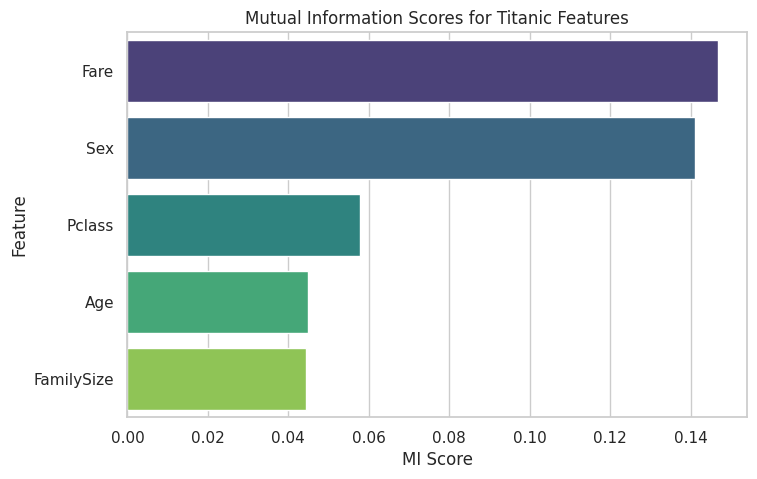

In [9]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Select features and target
X = train_df[['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare']]
y = train_df['Survived']

from sklearn.feature_selection import mutual_info_classif

# Compute MI scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto')

# Create a DataFrame for plotting
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df.sort_values('MI Score', ascending=False, inplace=True)


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=mi_df, x='MI Score', y='Feature', palette='viridis')
plt.title("Mutual Information Scores for Titanic Features")
plt.xlabel("MI Score")
plt.ylabel("Feature")

Based on the Mi scores above we can select useful features that will help us create a better predictive model.
so the features will be Sex,Fare,Pclass ,Family size and Age

In [10]:
features=['Sex','Fare','Pclass','FamilySize','Age']

#  Modeling**
Algorithms tested:

1. Logistic Regression
2. Random Forest




# **1. Logistic Regression**

Logistic regression is a classification algorithm used to predict binary outcomes — in this case, whether a passenger survived (1) or did not survive (0).



We will train the model using the train.csv and make predictions using test.csv

In [11]:
#train the model using the train_df
X = train_df[features]
y = train_df['Survived']

#X_test is the data we will use for predicting a our model 
X_test = test_df[features]



In [12]:

from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)


model_l=LogisticRegression()
model_l.fit(X_train,y_train)

y_pred=model_l.predict(X_val)
final_pred=model_l.predict(X_test)



In [13]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_pred
})

submission.to_csv('submission_0.csv', index=False)

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# **2.Random Forest**

Random Forest Works Well Here

1. Handles both numerical and categorical data.
2. Captures non-linear relationships.
3. Robust to outliers and missing data.
4. Provides feature importance for interpretability.








In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

# Train model
model = RandomForestClassifier( random_state=1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

final_prediction=model.predict(X_test)


In [15]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_prediction
})

submission.to_csv('submission_1.csv', index=False)

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# **Evaluating the best model**

To evaluate model performance reliably, I applied cross-validation using cross_val_score from scikit-learn. This technique splits the training data into multiple folds, trains the model on each fold, and averages the results to reduce bias from a single train-test split.

I compared Logistic Regression and Random Forest. Random Forest consistently achieved the highest average accuracy across folds, indicating strong generalization and robustness to overfitting.

This result suggests that Random Forest captures complex patterns in the data — such as interactions between features like Sex, Pclass, and FamilySize — better than linear models.

In [16]:

from sklearn.model_selection import cross_val_score

# Logistic Regression
log_scores = cross_val_score(LogisticRegression(), X, y, cv=5)
print("Logistic Regression CV Accuracy:", log_scores.mean())

# Random Forest
rf_scores = cross_val_score(RandomForestClassifier(), X, y, cv=5)
print("Random Forest CV Accuracy:", rf_scores.mean())


Logistic Regression CV Accuracy: 0.7912497646098802
Random Forest CV Accuracy: 0.8148578243675851


# **Feature importance**

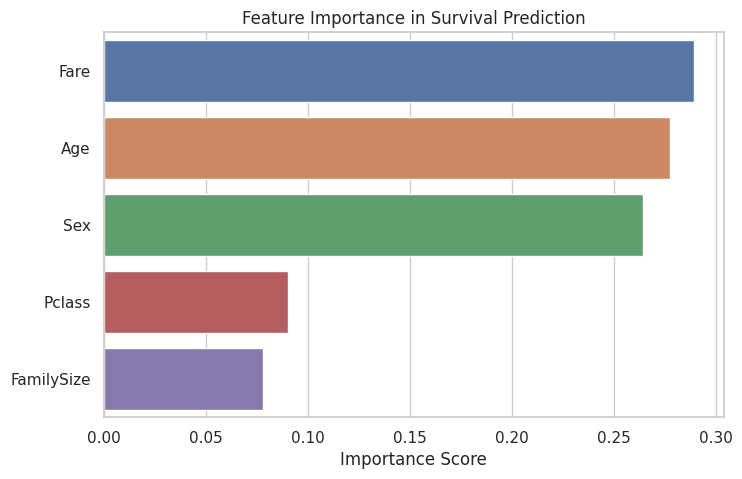

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance in Survival Prediction")
plt.xlabel("Importance Score")
plt.show()


# ** Conclusion**

The model successfully predicts survival with reasonable accuracy. Feature importance aligns with historical accounts, demonstrating how data science can uncover patterns in real-world events.